In [1]:
# Imports and environment setup
import sys, subprocess, requests, pyarrow, os
import pandas as pd
import datetime as dt
import dotenv
import dune_client
from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import QueryBase
import numpy as np
dotenv.load_dotenv(dotenv_path=dotenv.find_dotenv(filename=".env"))
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_extraction import (
    MinimalFCParameters, 
    EfficientFCParameters, 
    ComprehensiveFCParameters
)
import stumpy
# from CryptoPAForecastingTsfreshXGboost import My_FE_Wraps, My_FS_Wraps, My_API_Wraps, My_ML_Wraps 
import xgboost as xgb
from tsfresh import select_features

2025-09-19 14:58:37,167 INFO numba.cuda.cudadrv.driver init


In [ ]:
# # Dune API Call Function
# economic_security = 1933076
# daily_dex_volume = 4388
# btc_etf_flows = 5795477
# eth_etf_flows = 5795645
# total_defi_users= 2972
# median_gas= 2981260
# def fetch_dune_query(query_id, df=True):
#     DUNE_API_KEY = os.environ.get("DUNE_API_KEY")
#     dune = DuneClient(
#         api_key= DUNE_API_KEY,
#         request_timeout=120,
#         base_url="https://api.dune.com"
#     )
#     if df ==True:query_result =dune.get_latest_result_dataframe(query_id)
#     else: query_result = dune.get_latest_result(query_id)
#     return query_result

In [ ]:
# # X API Call Function
# X_BASE = "https://api.twitter.com/2"
# BEARER = os.environ.get("X_BEARER_TOKEN", "")

# def X_API_Call(data_request="Counts",
#                query="(ETH) lang:en -is:tweet",
#                granularity="day",
#                max_results=1,
#                start_time=dt.datetime.now()-dt.timedelta(days=1),
#                end_time=dt.datetime.now(),
#                next_token=None):
# 	headers = {"Authorization": f"Bearer {BEARER}"}

# 	if data_request == "Counts":
# 		path = "/tweets/counts/recent"
# 		params = {"query": query, "granularity": granularity}
# 		if start_time: params["start_time"] = start_time
# 		if end_time:   params["end_time"] = end_time
# 		if next_token: params["next_token"] = next_token

# 	elif data_request == "Search":
# 		path = "/tweets/search/recent"
# 		params = {
# 			"query": query,
# 			"max_results": max_results,
# 			"tweet.fields": "created_at,lang,public_metrics,author_id,referenced_tweets",
# 			"expansions": "author_id",
# 			"user.fields": "created_at,verified"
# 		}
# 		if start_time: params["start_time"] = start_time
# 		if end_time:   params["end_time"] = end_time
# 		if next_token: params["next_token"] = next_token

# 	else:
# 		return None

# 	url = X_BASE + path
# 	js = requests.get(url, headers=headers, params=params, timeout=20).json()
# 	return js

In [2]:
# Deribit API Call Function
def Deribit_API_Call(data_request="DVOL", currency="BTC", resolution='1D', days=31, instrument="BTC-5APR19", kind="option"):
    if data_request == "DVOL":
        rpc = {
            "method": "public/get_volatility_index_data",
            "params": {
                "currency":currency,
                "resolution":resolution,
                "end_timestamp": int(dt.datetime.now().timestamp())*1000,
                "start_timestamp": int((dt.datetime.now()-dt.timedelta(days=days)).timestamp())*1000
            }
        }
    elif data_request == "HVOL":
        rpc = {
            "method": "public/get_historical_volatility",
            "params": {
                "currency":currency,
                "resolution":resolution,
                "end_timestamp": int(dt.datetime.now().timestamp())*1000,
                "start_timestamp": int((dt.datetime.now()-dt.timedelta(days=days)).timestamp())*1000
            }
        }
    elif data_request == "Instruments":
        rpc = {
            "method": "public/get_instruments",
            "params": {"kind": kind}  
        }
    elif data_request == "TradingView":
        rpc = {
            "method": "public/get_tradingview_chart_data",
            "params": {
                "instrument_name": instrument,
                "resolution": resolution,
                "start_timestamp": int((dt.datetime.now()-dt.timedelta(days=days)).timestamp())*1000,
                "end_timestamp": int(dt.datetime.now().timestamp())*1000,
            }  
        }
    json = requests.post("https://www.deribit.com/api/v2/", json=rpc).json()
    return json['result']

In [3]:
# CoinGecko API Call Functions
# ID_MAP
def get_ID_map(coins):
    url = "https://api.coingecko.com/api/v3/coins/list"
    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": "CG-r57ENE22zzPUiLmjnflatdf['flatdf['flatdf['y']']']FK7YHw"
    }
    response = requests.get(url, headers=headers)
    id_map = pd.DataFrame(response.json()).set_index('name')
    return id_map.loc[coins]

# Top Coins by Marketcap- Investment Universe
def get_top_mc_coins(number):
    url = "https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd"
    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": "CG-r57ENE22zzPUiLmjnyFK7YHw"
    }
    response = pd.DataFrame(requests.get(url, headers=headers).json())
    current_stats= response.drop(['image', 'roi', 'last_updated'], axis=1)
    investment_universe = response.head(number)['id'].values
    return current_stats, investment_universe

# HISTORICAL PRICE ACTION
# API restraints = [only up to last 365, more than 90 days lose hourly granularity]
def get_raw_data(coins, days):
    raw_data= {}
    end = int(dt.datetime.now().timestamp())*1000
    start= int((dt.datetime.now()-dt.timedelta(days=days)).timestamp())*1000
    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": "CG-r57ENE22zzPUiLmjnyFK7YHw"
    }
    for coin in coins:
        try:
            url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range?vs_currency=usd&from={start}&to={end}"
            response = requests.get(url, headers=headers)
            raw_data[coin] = response.json()
        except: continue
    return raw_data

def get_chart_data(coins, days):
    if days <=1: freq= '5min'
    else: freq='h'
    end = int(dt.datetime.now().timestamp())*1000
    start= int((dt.datetime.now()-dt.timedelta(days=days)).timestamp())*1000
    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": "CG-r57ENE22zzPUiLmjnyFK7YHw"
    }
    historicals = {}
    for coin in coins:
        try:
            url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range?vs_currency=usd&from={start}&to={end}"
            response = requests.get(url, headers=headers)
            prices = pd.DataFrame(response.json()['prices'], columns= ['datetime', f'prices_{coin}'])
            marketcaps = pd.DataFrame(response.json()['market_caps'], columns= ['datetime', f'marketcaps_{coin}'])
            total_vol= pd.DataFrame(response.json()['total_volumes'], columns= ['datetime', f'total_volumes_{coin}'])
            historicals[coin] = pd.merge(prices, marketcaps)
            historicals[coin] = pd.merge(historicals[coin],total_vol)
            historicals[coin]['datetime'] = historicals[coin]['datetime'] 
            historicals[coin]['datetime'] = historicals[coin]['datetime'].apply(pd.to_datetime, unit='ms', utc=True)
            historicals[coin].set_index('datetime', inplace=True)
            historicals[coin].index = historicals[coin].index.tz_convert('CET')
            historicals[coin]= historicals[coin].resample(freq).last().ffill().dropna()
        except:continue
    return historicals



In [ ]:
# # Dune Metrics: Collection & Processing (daily, all timeframes)
# # daily dex vol: 1month max
# # btc etf flows: 1month max
# # economic security: all time
# btcetfflows = fetch_dune_query(btc_etf_flows)
# btcetfflows= btcetfflows.rename(columns={'time':'day'})
# btcetfflows= btcetfflows.rename(columns={'amount_usd':'btc_etf_flows'})
# btcetfflows= btcetfflows[['day','btc_etf_flows']].groupby('day').sum()
# btcetfflows.index = pd.to_datetime(btcetfflows.index)
# econosec= fetch_dune_query(economic_security)
# econosec['time']= pd.to_datetime(econosec['time'])
# econosec.rename(columns={'time':'day'}, inplace=True)
# econosec= econosec.set_index('day').sort_index().drop('staked_validators', axis=1)
# dailydexvol= fetch_dune_query(daily_dex_volume)
# dailydexvol= dailydexvol.drop('project', axis=1)
# dailydexvol['usd_volume']= pd.to_numeric(dailydexvol['usd_volume'], errors='coerce')
# dailydexvol= dailydexvol.rename(columns={'_col1':'day'})
# dailydexvol= dailydexvol.groupby('day').sum()
# dailydexvol.index = pd.to_datetime(dailydexvol.index)
# dune =btcetfflows.join(econosec, how='inner').join(dailydexvol, how='inner').tzlocalize(None)
# dune

In [ ]:
# # Dune Metrics: Collection & Processing (daily, only unconstrained timeframes)
# econosec= fetch_dune_query(economic_security)
# econosec['time']= pd.to_datetime(econosec['time'])
# econosec.rename(columns={'time':'date'}, inplace=True)
# econosec= econosec.set_index('date').sort_index().drop('staked_validators', axis=1)
# btcetfflows = fetch_dune_query(btc_etf_flows)
# btcetfflows= btcetfflows.rename(columns={'time':'date'})
# btcetfflows= btcetfflows.rename(columns={'amount_usd':'btc_etf_flows(usd)'})
# btcetfflows= btcetfflows[['date','btc_etf_flows(usd)']].groupby('date').sum()
# btcetfflows.index = pd.to_datetime(btcetfflows.index)
# totaldefiusers= fetch_dune_query(total_defi_users).set_index('date').sort_index()
# totaldefiusers.index= pd.to_datetime(totaldefiusers.index)
# totaldefiusers= totaldefiusers.tz_localize(None)
# mediangas= fetch_dune_query(median_gas)
# mediangas.rename(columns={'time':'date'}, inplace=True)
# mediangas.set_index('date', inplace=True)
# mediangas.index = pd.to_datetime(mediangas.index)
# mediangas= mediangas.tz_localize(None)
# mediangas = mediangas.drop('median_eth_transfer_gas', axis=1).sort_index()
# ethetfflows = fetch_dune_query(eth_etf_flows)
# ethetfflows= ethetfflows.rename(columns={'time':'date'})
# ethetfflows= ethetfflows.rename(columns={'net_flow_usd':'eth_etf_flows(usd)'})
# ethetfflows['eth_etf_flows(usd)'] = pd.to_numeric(ethetfflows['eth_etf_flows(usd)'], errors='coerce')
# ethetfflows= ethetfflows[['date','eth_etf_flows(usd)']].groupby('date').sum()
# ethetfflows.index = pd.to_datetime(ethetfflows.index)
# dune = econosec.tz_localize(None).join(btcetfflows.tz_localize(None), how='inner').join(totaldefiusers, how='inner').join(mediangas, how='inner').join(ethetfflows, how='inner')

In [4]:
# Load Dune Metrics from CSV
dune = pd.read_csv('OutputData/Dune_Metrics.csv', index_col='date', parse_dates=True)
dune

,cum_deposited_eth,economic_security,cum_validators,btc_etf_flows(usd),total_users,median_gas,median_eth_transfer_price,eth_etf_flows(usd)
date,,,,,,,,
2024-09-17,3.452897e+07,7.932030e+10,1.079030e+06,3.224055e+07,95422221.0,6.113563,0.294927,-9.618776e+06
2024-09-18,3.452850e+07,8.090890e+10,1.079016e+06,1.668021e+08,96218032.0,8.841628,0.435081,-1.504934e+07
2024-09-19,3.451697e+07,8.180936e+10,1.078655e+06,-5.631802e+07,96965181.0,17.473514,0.869701,-9.983615e+06
2024-09-20,3.451038e+07,8.507912e+10,1.078449e+06,1.647916e+08,97759057.0,15.499529,0.802437,5.228593e+06
2024-09-21,3.451713e+07,8.838974e+10,1.078660e+06,0.000000e+00,98484323.0,12.132593,0.652439,0.000000e+00
...,...,...,...,...,...,...,...,...
2025-09-04,3.675297e+07,1.635742e+11,1.148530e+06,1.570136e+08,280376013.0,0.977605,0.091370,-2.815556e+08
2025-09-05,3.671150e+07,1.579112e+11,1.147234e+06,-9.442128e+07,280740555.0,0.706724,0.063838,2.929931e+07
2025-09-06,3.667117e+07,1.580296e+11,1.145974e+06,-3.933138e-03,281032904.0,0.337402,0.030534,0.000000e+00


In [5]:
# Deribit DVOL (volatility-index based on options market): Collection & Processing (All granularities & max days available)
Dvol_raw= Deribit_API_Call(data_request="DVOL", currency="BTC", resolution='1D', days=365)['data']
Dvol = pd.DataFrame(Dvol_raw, columns=['day', 'open', 'high', 'low', 'Dvol']).set_index('day')
Dvol.index = pd.to_datetime(Dvol.index, unit='ms')
Dvol.sort_index(inplace=True)
Dvol = Dvol['Dvol']

In [6]:
# CoinGecko Price Action (price, MC, volume): Collection & Processing (max 365 days)
coins = get_top_mc_coins(10)[1]
timeframe = 365
price_data = get_chart_data(coins, timeframe)

In [7]:
# Combined Dataset for Modeling
target = 'ethereum'
OCA= dune.join(Dvol, how='inner')
for coin in coins:
    x = price_data[coin].tz_localize(None).groupby(pd.Grouper(freq='D')).last().ffill()
    OCA = OCA.join(x, how='inner')


In [ ]:
# # Load combined dataset from file
# OCA = pd.read_csv('OutputData/OCA_firstdiff.csv', parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')

In [8]:
# Target Definintion & Computation
target = 'ethereum'
OCA[f'realized_vol_{target}'] = abs(OCA[f'prices_{target}'].pct_change())
OCA_firstdiff= OCA.diff().dropna()

In [9]:
# Correlations with target 
corrwithstandard=abs(OCA.corr()['realized_vol_ethereum']).sort_values(ascending=False)
# first diff correlations with target 
corrwithdiff= abs(OCA_firstdiff.corr()['realized_vol_ethereum']).sort_values(ascending=False)
# pct change correlations with target
corrwithpctchange= abs(OCA.pct_change().corr()['realized_vol_ethereum']).sort_values(ascending=False)

In [10]:
# mean correlations
print('avgcorrwithstandard '+ str(np.mean(corrwithstandard)))
print('avgcorrwithpctchange '+ str(np.mean(corrwithpctchange)))
print('avgcorrwithdiff '+ str(np.mean(corrwithdiff)))

avgcorrwithstandard 0.09399096272457996
avgcorrwithpctchange 0.08491680051711378
avgcorrwithdiff 0.0965280324870568


In [ ]:
# # CPU optimized cluster for my CPU 
# from dask.distributed import Client, LocalCluster
# from tsfresh.utilities.distribution import (
#     ClusterDaskDistributor, 
#     MultiprocessingDistributor
# )
# cluster = LocalCluster(
#             n_workers=4,
#             threads_per_worker=5,
#             processes=True,
#             dashboard_address=':8787',
#             resources = {'GPU':2}
#         )
# client = Client(cluster)
# client

In [10]:
# Stacked & Rolled Dataframe Construction
stacked= OCA_firstdiff.reset_index().melt(id_vars=['index'])
rolled= roll_time_series(stacked, column_id='variable', column_sort='index', max_timeshift=7, n_jobs=18)
rolled=rolled.dropna()

Rolling: 100%|██████████| 88/88 [00:17<00:00,  4.99it/s]


In [11]:
# Feature Extraction with tsfresh
features_raw= extract_features(
    rolled, column_id='id', column_sort='index', 
    column_kind='variable', column_value='value', 
    default_fc_parameters=ComprehensiveFCParameters(), 
    n_jobs=18
)
count=0
for key in features_raw.index.levels[0]:
    if count == 0: df= features_raw.loc[key].dropna(axis=1)
    else: df = df.merge(features_raw.loc[key].dropna(axis=1), left_index=True, right_index=True, how='inner')
    count += 1
features = df

2025-09-19 15:01:08,777 WARNING tsfresh.feature_extraction.settings Dependency not available for matrix_profile, this feature will be disabled!
Feature Extraction: 100%|██████████| 90/90 [07:33<00:00,  5.04s/it] 


In [12]:
# Target Construction & test train split
y_future= OCA_firstdiff['realized_vol_ethereum'].shift(-1).rename('y_future')
fullfeat=features.join(y_future, how='inner')
fullfeat.dropna(inplace=True)
fullfeat.to_csv('OutputData/fullfeat.csv')
X_train = fullfeat.drop('y_future', axis=1).iloc[ : int(-len(fullfeat)/10)]
y_train = fullfeat['y_future'].iloc[ : int(-len(fullfeat)/10)]
X_test = fullfeat.drop('y_future', axis=1).iloc[int(-len(fullfeat)/10) : ]
y_test = fullfeat['y_future'].iloc[int(-len(fullfeat)/10) : ]

In [13]:
# Select Features
X_train_filtered = select_features(
    X_train, y_train, hypotheses_independent=False, 
    ml_task='regression', n_jobs=20, fdr_level=0.1 
)

In [14]:
X_train_filtered

,marketcaps_staked-ether__energy_ratio_by_chunks__num_segments_10__segment_focus_7,marketcaps_ethereum__energy_ratio_by_chunks__num_segments_10__segment_focus_7,prices_ethereum__energy_ratio_by_chunks__num_segments_10__segment_focus_7,prices_staked-ether__energy_ratio_by_chunks__num_segments_10__segment_focus_7,economic_security__energy_ratio_by_chunks__num_segments_10__segment_focus_7,marketcaps_ethereum__index_mass_quantile__q_0.9,marketcaps_staked-ether__index_mass_quantile__q_0.9,prices_ethereum__index_mass_quantile__q_0.9,economic_security__index_mass_quantile__q_0.9,realized_vol_ethereum__sum_values,...,realized_vol_ethereum__quantile__q_0.9,prices_dogecoin__index_mass_quantile__q_0.9,marketcaps_dogecoin__index_mass_quantile__q_0.9,marketcaps_staked-ether__index_mass_quantile__q_0.4,prices_binancecoin__index_mass_quantile__q_0.7,prices_staked-ether__index_mass_quantile__q_0.4,"total_volumes_staked-ether__fft_coefficient__attr_""angle""__coeff_0",prices_ethereum__index_mass_quantile__q_0.4,realized_vol_ethereum__index_mass_quantile__q_0.8,"economic_security__agg_autocorrelation__f_agg_""var""__maxlag_40"
2024-09-22,0.000000,0.000000,0.000000,0.000000,0.000000,1.000,1.000,1.000,1.000,-0.015198,...,-0.015198,1.000,1.000,1.000000,1.000,1.000000,180.0,1.000000,1.000,0.000000
2024-09-23,0.000000,0.000000,0.000000,0.000000,0.000000,1.000,1.000,1.000,1.000,-0.025332,...,-0.010640,1.000,1.000,0.500000,0.500,0.500000,180.0,0.500000,1.000,0.000000
2024-09-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000,1.000,1.000,1.000,-0.012254,...,0.008436,1.000,1.000,0.666667,1.000,0.666667,0.0,0.666667,1.000,0.508988
2024-09-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.750,0.750,0.750,0.750,-0.035266,...,0.006115,1.000,1.000,0.500000,0.750,0.500000,180.0,0.500000,1.000,0.546480
2024-09-26,0.000000,0.000000,0.000000,0.000000,0.000000,1.000,1.000,1.000,1.000,-0.009110,...,0.020925,0.800,0.800,0.600000,1.000,0.600000,180.0,0.600000,1.000,0.436689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-30,0.002358,0.000374,0.000127,0.000182,0.000163,0.875,0.875,0.875,0.875,-0.001216,...,0.026589,0.875,0.875,0.375000,0.750,0.375000,180.0,0.375000,0.875,0.192076
2025-07-31,0.011438,0.008568,0.008509,0.008955,0.005972,0.750,0.750,0.750,0.750,0.000051,...,0.026589,0.750,0.750,0.250000,0.750,0.250000,180.0,0.250000,0.875,0.234245
2025-08-01,0.386409,0.313752,0.304957,0.284935,0.290090,1.000,1.000,1.000,1.000,-0.002106,...,0.025079,1.000,1.000,0.500000,0.625,0.500000,180.0,0.500000,1.000,0.466150
2025-08-02,0.593282,0.591985,0.572153,0.560021,0.571585,1.000,1.000,1.000,1.000,0.036159,...,0.027717,1.000,1.000,0.750000,0.750,0.500000,180.0,0.500000,1.000,0.236915


In [15]:
# Fit & Assess Performance of Simple XGBoost Model
base_model = xgb.XGBRegressor(
        eval_metric='mae',
        verbosity=0,
        early_stopping_rounds=10,
    )
eval_model= base_model.fit(X_train_filtered, y_train, eval_set=[(X_train_filtered, y_train)], verbose=10)
print("Best Score: ", eval_model.best_score)
print("Best Score / Median y: ", eval_model.best_score/np.median(abs(y_train)))
# Prediction best scores log (timeshift = 7, 1 period ahead, change in volatility):
# Best Score:  0.00045465779426869
# Best Score / Median y:  0.024029231129997403 

[0]	validation_0-mae:0.02067
[10]	validation_0-mae:0.00509
[20]	validation_0-mae:0.00203
[30]	validation_0-mae:0.00086
[40]	validation_0-mae:0.00039
[50]	validation_0-mae:0.00039
[60]	validation_0-mae:0.00039
[64]	validation_0-mae:0.00039
Best Score:  0.00039375906831256
Best Score / Median y:  0.02080975824607614


R^2:  0.42702229219375376


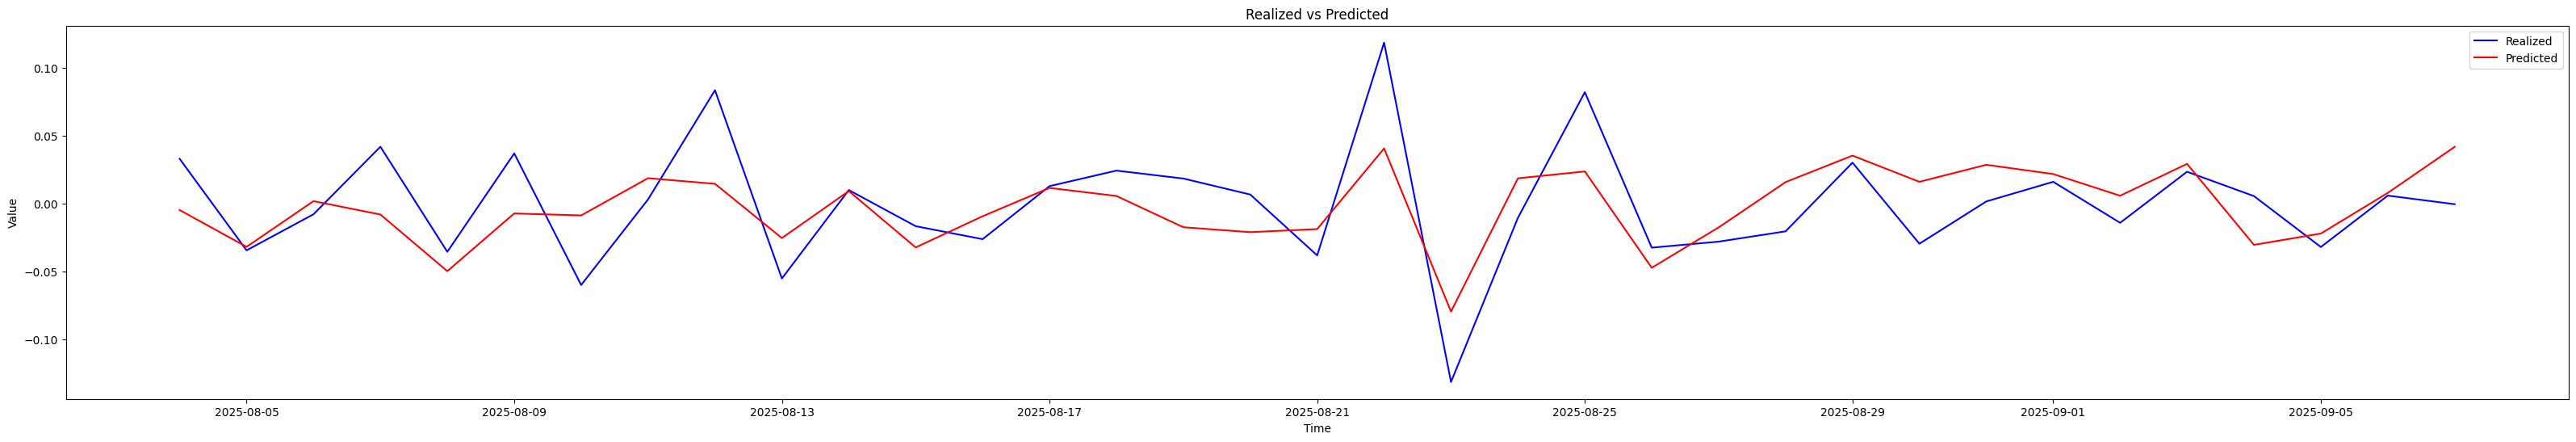

In [16]:
# Predictions & Visualization
predictions= base_model.predict(X_test[X_train_filtered.columns])
realized = y_test
from sklearn.metrics import r2_score
print("R^2: ", r2_score(realized, predictions))
import matplotlib.pyplot as plt
plt.figure(figsize=(40,6))
plt.plot(realized.index, realized, label='Realized', color='blue')
plt.plot(realized.index, predictions, label='Predicted', color='red')
plt.title('Realized vs Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Compute MASE for model predictions: below 0.5 is very good for timeseries = model error less than half of naive
mae_model = np.mean(np.abs(realized - predictions))
naive_pred = realized.shift(1)
mae_naive = np.mean(np.abs(realized[1:] - naive_pred[1:]))
mase = mae_model / mae_naive
print("MASE:", mase)

MASE: 0.4657745589697888


In [ ]:
# Predict Tomorrow's Change in Volatility:
latest_features= features.iloc[-1:][X_train_filtered.columns]
pred_tomorrow= base_model.predict(latest_features)
pd.DataFrame(pred_tomorrow, columns=['Predicted Change in Volatility'], index=[features.index[-1] + pd.Timedelta(days=1)])

In [ ]:
# Feature Importance
featureimportances=pd.DataFrame(base_model.feature_importances_, index=X_train_filtered.columns, columns=['importance']).sort_values('importance', ascending=False)
featureimportances[featureimportances['importance']>0]